In [1]:
import time

import adi
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from timeit import default_timer as timer

In [3]:
def plotfigure(ts, data0):
    f, Pxx_den = signal.periodogram(data0, int(1/ts))
    Npoints=len(data0)
    t = (ts*1000)*np.arange(Npoints) #second to ms
    fig, axs = plt.subplots(2, 1, layout='constrained', figsize=(12,6))
    axs[0].cla()  
    axs[0].plot(t, data0.real, marker="o", ms=2, color="red")  # Only plot real part
    #axs[0].plot(t, data1.real, marker="o", ms=2, color="blue")
    #axs[0].set_xlim(0, 2)
    axs[0].set_xlabel('Time (ms)')
    axs[0].set_ylabel('data0')
    axs[0].set_title("Time Domain Dual Ch Data")
    axs[0].grid(True)
    axs[1].cla()  
    axs[1].semilogy(f/1e6, Pxx_den)
    axs[1].set_ylim([1e-7, 1e2])
    axs[1].set_xlabel("frequency [MHz]") #-3e^6 3e^6
    axs[1].set_ylabel("PSD [V**2/Hz]")
    axs[1].set_title("Spectrum")
    plt.show()

def loadad9361data():
    with open('./data/ad9361data.npy', 'rb') as f:
        alldata = np.load(f)
    print(len(alldata))
    fs= 6000000 #6MHz
    ts = 1/float(fs)
    num_samps = 1024*100
    plotfigure(ts, alldata.real[0:num_samps*2])
    Nperiod=int(2*fs/num_samps)
    print(len(alldata)/num_samps)

def showspectrum(data, fs, N_frame):
    data=data[0:N_frame]
    win_funct = np.blackman(len(data))
    y = data * win_funct
    sp = np.absolute(np.fft.fft(y))
    sp = np.fft.fftshift(sp)
    s_mag = np.abs(sp) / np.sum(win_funct)
    s_mag = np.maximum(s_mag, 10 ** (-15))
    s_dbfs = 20 * np.log10(s_mag / (2 ** 11))
    """there's a scaling issue on the y-axis of the waterfallcthe data is off by 300kHz.  To fix, I'm just shifting the freq"""
    # data_shift = data * iq_300k
    # y = data_shift * win_funct
    # sp = np.absolute(np.fft.fft(y))
    # sp = np.fft.fftshift(sp)
    # s_mag = np.abs(sp) / np.sum(win_funct)
    # s_mag = np.maximum(s_mag, 10 ** (-15))
    # s_dbfs_shift = 20 * np.log10(s_mag / (2 ** 11))
    #dist, s_dbfs
    #freq, s_dbfs
    freq = np.linspace(-fs / 2, fs / 2, int(N_frame))
    plt.figure(figsize=(10,6))
    plt.plot(freq,s_dbfs)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.title('Spectrum')
    plt.show()

In [29]:
with open('../data/radardata5s-people.npy', 'rb') as f:
        alldata = np.load(f)
print(len(alldata))
sample_rate = 0.6e6 #0.6M
fs = sample_rate
center_freq = 2.1e9 #2.1G
signal_freq = 100e3 #100K
num_slices = 200
fft_size = 1024 * 16 #16384
ts = 1/float(fs)

2998272


In [33]:
Nperiod=int(5*fs/fft_size) 
print("Total period:", Nperiod)

Total period: 183


In [34]:
Nd=int(len(alldata)/fft_size) #70
Nd

183

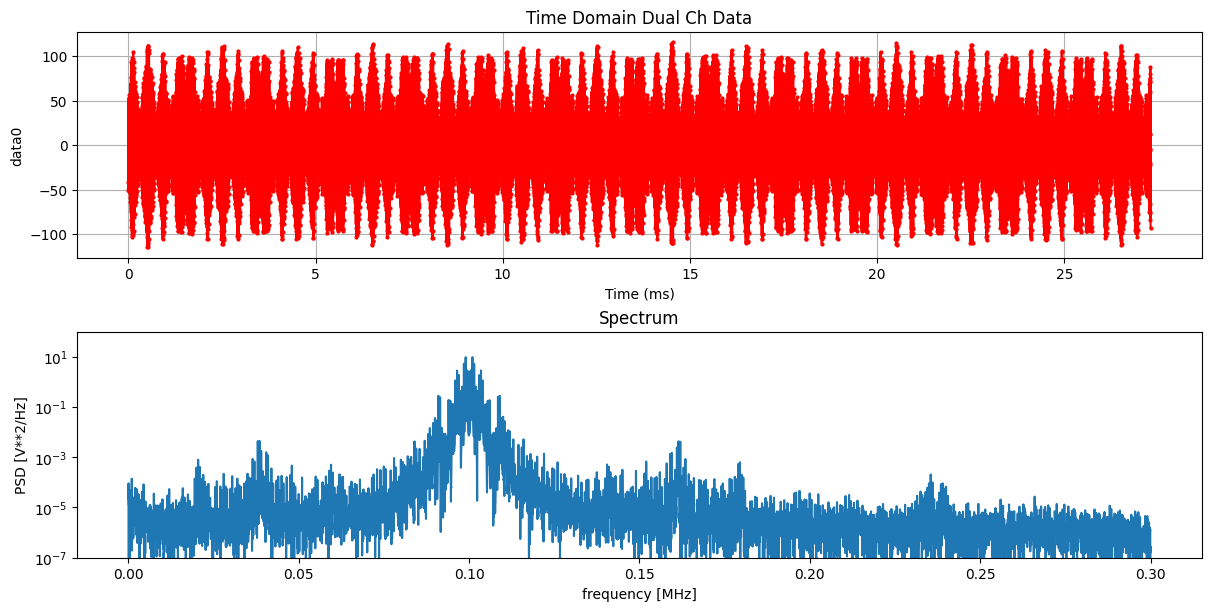

In [31]:
plotfigure(ts, alldata.real[0:fft_size])

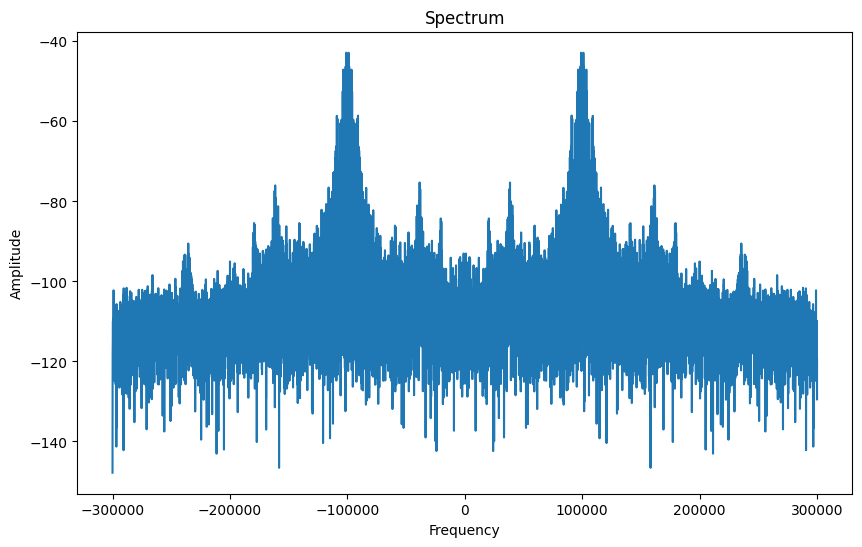

In [35]:
N_frame = fft_size
c = 3e8
BW = 500e6
num_steps = 1000
ramp_time = 1e3  # us
ramp_time_s = ramp_time / 1e6
slope = BW / ramp_time_s
showspectrum(alldata.real, fs, N_frame)

In [36]:
Nr = int(ramp_time_s * fs) #Number ADC sampling points in each chirp
Nr

600

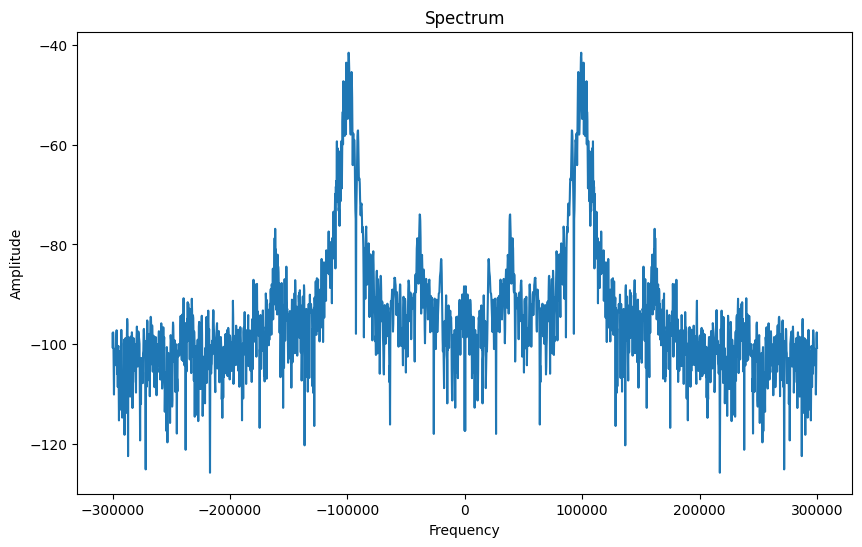

In [37]:
showspectrum(alldata.real, fs, Nr*4)

C:\Users\lkk68\AppData\Local\Temp\ipykernel_10756\719206391.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  mat2D[i, :] = alldata[i*newfft_size:(i+1)*newfft_size]


Text(0.5, 1.0, '2D original data')

<Figure size 1000x600 with 0 Axes>

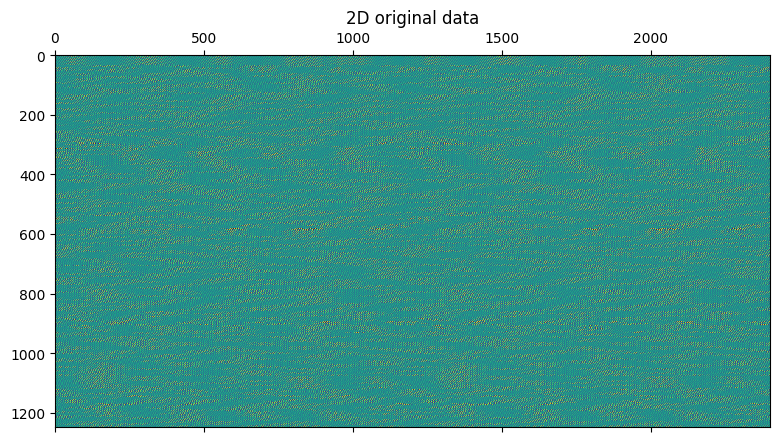

In [38]:
#2D plot
newfft_size = Nr *4
Nd=int(len(alldata)/newfft_size) #70
mat2D = np.zeros((Nd, newfft_size)) #128 chirps * 1024 samples/chirp
i = 0
while(i<Nd):
    mat2D[i, :] = alldata[i*newfft_size:(i+1)*newfft_size]
    i = i + 1
plt.figure(figsize=(10,6))
plt.matshow(mat2D)
plt.title('2D original data')

Text(0.5, 1.0, 'IF Signal FFT')

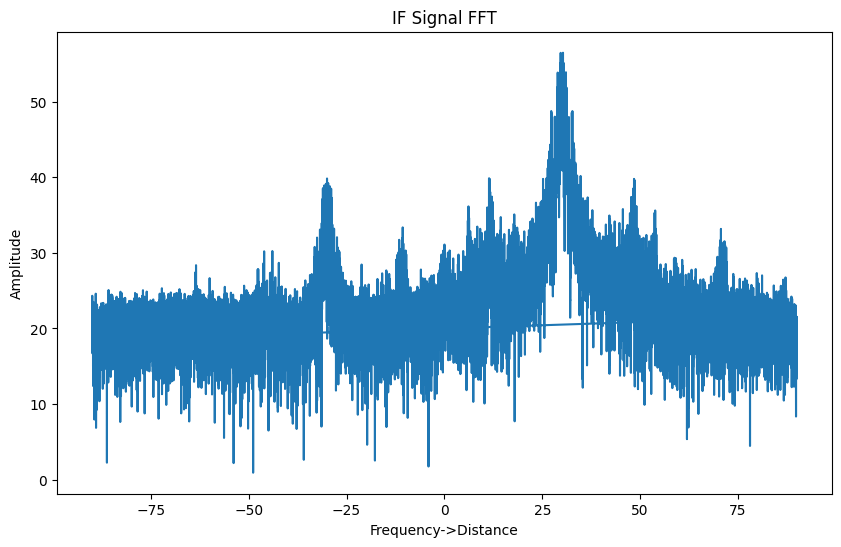

In [39]:
#Range FFT
doppler = 10*np.log10(np.abs(np.fft.fft(alldata[0:fft_size]))) #(1024,)
frequency = np.fft.fftfreq(fft_size, 1/fs)
range = frequency*c/(2*slope)
plt.figure(figsize=(10,6))
plt.plot(range[0:fft_size],doppler[0:fft_size])
plt.xlabel('Frequency->Distance')
plt.ylabel('Amplitude')
plt.title('IF Signal FFT')

Text(0.5, 1.0, 'Range-Frequency Spectogram')

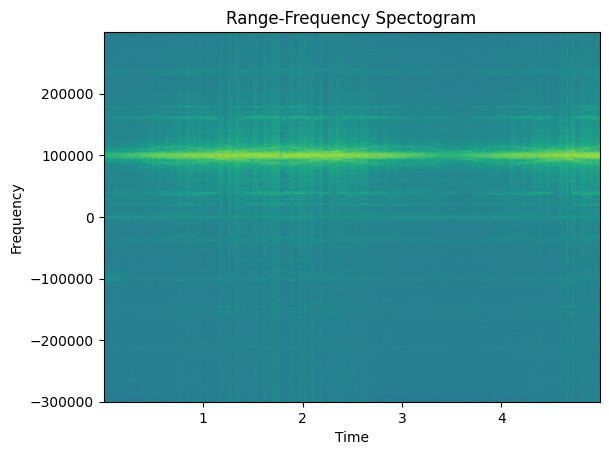

In [40]:
plt.specgram(alldata,fft_size,fs)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Range-Frequency Spectogram')

In [52]:
def dynamicspectrum(dataall, fs, N_frame):
    totallen=len(dataall)
    Ntotalframe=int(totallen/N_frame)-1
    print(Ntotalframe)
    plt.figure(figsize=(10,6))
    for i in range(int(Ntotalframe)):
        data = dataall[i*N_frame:(i+1)*N_frame]
        #data=data[0:N_frame]
        win_funct = np.blackman(len(data))
        y = data * win_funct
        sp = np.absolute(np.fft.fft(y))
        sp = np.fft.fftshift(sp)
        s_mag = np.abs(sp) / np.sum(win_funct)
        s_mag = np.maximum(s_mag, 10 ** (-15))
        s_dbfs = 20 * np.log10(s_mag / (2 ** 11))
        freq = np.linspace(-fs / 2, fs / 2, int(N_frame))
        plt.clf()
        plt.plot(freq,s_dbfs)
        plt.xlabel('Frequency')
        plt.ylabel('Amplitude')
        plt.title('Spectrum')
        #plt.show()
        plt.draw()
        plt.pause(0.1)

In [53]:
dynamicspectrum(alldata, fs, fft_size)

182


TypeError: 'numpy.ndarray' object is not callable

<Figure size 1000x600 with 0 Axes>

In [41]:
mat2D.shape

(1249, 2400)

In [44]:
newmat2D=mat2D[0:600,0:1024].copy()

Text(0.5, 1.0, 'Velocity-Range 2D FFT')

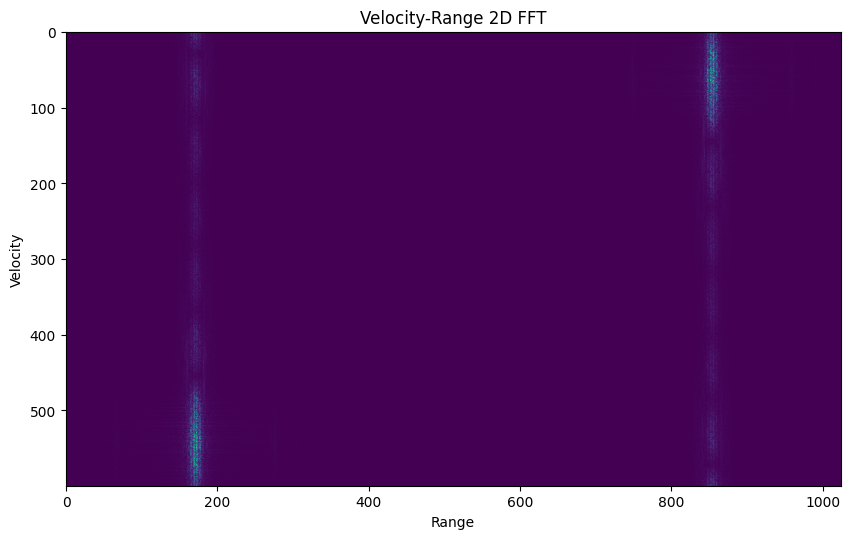

In [45]:
Z_fft2 = abs(np.fft.fft2(newmat2D)) #(128, 1024)
Data_fft2 = Z_fft2#[0:64,0:512] #get half
#plt.subplot(4,2,8)
plt.figure(figsize=(10,6))
plt.imshow(Data_fft2) #(64, 512)
plt.xlabel("Range")
plt.ylabel("Velocity")
plt.title('Velocity-Range 2D FFT')